In [1]:
import sys
sys.path.insert(0, "/home/herb/WRK/ken/l5kit_repo/l5kit")

from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.dataset.dataloader_builder import build_dataloader
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_coords_as_csv, compute_mse_error_csv
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable

import os

## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/home/herb/WRK/ken/data"
# get config
cfg = load_config_data("./agent_motion_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5}, 'train_data_loader': {'datasets': [{'key': 'sample_scenes/sample.zarr', 'scene_indices': [-1]}], 'perturb_probability': 0, 'batch_size': 12, 'shuffle': True, 'num_workers': 16}, 'val_data_loader': {'datasets': [{'key': 'sample_scenes/sample.zarr', 'scene_indices': [-1]}], 'perturb_probability': 0, 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


## Model

Our baseline is a simple `resnet50` pretrained on `imagenet`. We must replace the input and the final layer to address our requirements.

In [3]:
def build_model(cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = resnet50(pretrained=True)

    # change input size
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size
    # X, Y  * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model

In [4]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    targets = data["target_positions"].to(device).reshape(len(data["target_positions"]), -1)
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss = loss.mean()
    return loss, outputs

## Load the data and initialise the model

In [5]:
dm = LocalDataManager(None)
# ===== INIT DATASETS
rasterizer = build_rasterizer(cfg, dm)
train_dataloader = build_dataloader(cfg, "train", dm, AgentDataset, rasterizer)
eval_dataloader = build_dataloader(cfg, "val", dm, AgentDataset, rasterizer)

meta.json is not present in local data folder /home/herb/WRK/ken/data
!!dataset metafile not found!! the hard-coded matrix will be loaded.
This will be deprecated in future releases


In [6]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = build_model(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction="none")

# Training

In [7]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)

    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

loss: 201.0548553466797 loss(avg): 194.7693664550781: 100%|██████████| 5/5 [00:02<00:00,  2.23it/s]  


# Evaluation
We can now run inference and store predicted and annotated trajectories. 

In this example, we run it on a single scene from the eval dataset because of computational constraints. 

In [8]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)
losses_eval = []

# store information for evaluation
future_coords_offsets_pd = []
future_coords_offsets_gt = []

timestamps = []
agent_ids = []
progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    loss, ouputs = forward(data, model, device, criterion)
    losses_eval.append(loss.item())
    progress_bar.set_description(f"Running EVAL, loss: {loss.item()} loss(avg): {np.mean(losses_eval)}")

    future_coords_offsets_pd.append(ouputs.reshape(len(ouputs), -1, 2).cpu().numpy().copy())
    future_coords_offsets_gt.append(data["target_positions"].reshape(len(ouputs), -1, 2).cpu().numpy().copy())

    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    

Running EVAL, loss: 153.29689025878906 loss(avg): 165.00677985577522: 100%|██████████| 3445/3445 [04:33<00:00, 12.59it/s]


### Save results  and perform evaluation
After the model has predicted trajectories for our evaluation set, we can save them in a `csv` file. To simulate a complete evaluation session we can also save the ground truth in another `csv` and get the score.

We will get `future_num_frames` values, corresponding to the Displacement Error (mean of squared errors / l2-loss between predicted point and ground truth point) for that timestep.

In [9]:
# ==== COMPUTE CSV
pred_path = f"{gettempdir()}/pred.csv"
gt_path = f"{gettempdir()}/gt.csv"

write_coords_as_csv(pred_path, future_num_frames=cfg["model_params"]["future_num_frames"],
                    future_coords_offsets=np.concatenate(future_coords_offsets_pd),
                    timestamps=np.concatenate(timestamps),
                    agent_ids=np.concatenate(agent_ids))
write_coords_as_csv(gt_path, future_num_frames=cfg["model_params"]["future_num_frames"],
                    future_coords_offsets=np.concatenate(future_coords_offsets_gt),
                    timestamps=np.concatenate(timestamps),
                    agent_ids=np.concatenate(agent_ids))
# get a pretty visualisation of the errors
table = PrettyTable(field_names=["future step", "MSE"])
table.float_format = ".2"
steps = range(1, cfg["model_params"]["future_num_frames"] + 1)
errors = compute_mse_error_csv(gt_path, pred_path)
for step_idx, step_mse in zip(steps, errors):
    table.add_row([step_idx, step_mse])
print(table)



+-------------+--------+
| future step |  MSE   |
+-------------+--------+
|      1      |  0.67  |
|      2      |  0.90  |
|      3      |  1.78  |
|      4      |  3.12  |
|      5      |  4.63  |
|      6      |  6.64  |
|      7      |  9.03  |
|      8      | 11.93  |
|      9      | 15.12  |
|      10     | 18.84  |
|      11     | 23.17  |
|      12     | 28.45  |
|      13     | 32.66  |
|      14     | 38.24  |
|      15     | 43.35  |
|      16     | 50.15  |
|      17     | 55.13  |
|      18     | 63.02  |
|      19     | 70.12  |
|      20     | 77.78  |
|      21     | 85.31  |
|      22     | 93.76  |
|      23     | 103.41 |
|      24     | 111.20 |
|      25     | 120.23 |
|      26     | 131.42 |
|      27     | 141.66 |
|      28     | 149.87 |
|      29     | 160.82 |
|      30     | 173.19 |
|      31     | 185.26 |
|      32     | 196.78 |
|      33     | 208.79 |
|      34     | 223.58 |
|      35     | 236.70 |
|      36     | 248.08 |
|      37     | 264.07 |


### Visualise Results
We can also visualise some results from the ego (AV) point of view. 

We can use the `get_frame_indices` function to find a frame with interesting agents.

(5, 224, 224)
(224, 224, 3)


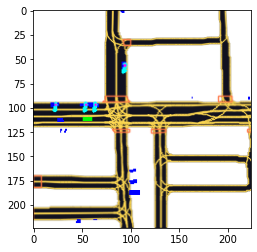

In [16]:
eval_agent_dataset = eval_dataloader.dataset.datasets[0].dataset
eval_ego_dataset = EgoDataset(cfg, eval_agent_dataset.dataset, rasterizer)

# get the first non-zero agents frame
frame_number = -1
min_agents_to_pick = 4
for idx_frame in range(len(eval_ego_dataset.dataset.frames)):
    if len(eval_agent_dataset.get_frame_indices(idx_frame)) >= min_agents_to_pick:
        frame_number = idx_frame
        break
if frame_number == -1:
    raise ValueError(f"can't find a frame with at least {min_agents_to_pick} agents in it")

model.eval()
torch.set_grad_enabled(False)

# get AV point-of-view frame
data_ego = eval_ego_dataset[frame_number]
print(data_ego["image"].shape)
im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
print(im_ego.shape)

center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
agent_indices = eval_agent_dataset.get_frame_indices(frame_number)
predicted_positions = []
target_positions = []

for v_index in agent_indices:
    data_agent = eval_agent_dataset[v_index]

    out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
    out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
    
    # store absolute world coordinates
    predicted_positions.append(out_pos + data_agent["centroid"][:2])
    target_positions.append(data_agent["target_positions"] + data_agent["centroid"][:2])

# print("Predicted positions:")
# print(predicted_positions[:5])
# print("Target positions:")
# print(target_positions[:5])

# convert coordinates to AV point-of-view so we can draw them
predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["world_to_image"])
target_positions = transform_points(np.concatenate(target_positions), data_ego["world_to_image"])

# print("Predicted positions:")
# print(predicted_positions[:5])
# print("Target positions:")
# print(target_positions[:5])

yaws = np.zeros((len(predicted_positions), 1))
draw_trajectory(im_ego, predicted_positions, yaws, PREDICTED_POINTS_COLOR)
draw_trajectory(im_ego, target_positions, yaws, TARGET_POINTS_COLOR)

plt.imshow(im_ego[::-1])